<a href="https://colab.research.google.com/github/MasaAsami/modified_DMLDiD_RCS/blob/main/notebooks/Reproduction_of_DMLDiD_RCS_with_SIMDATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MasaAsami/modified_DMLDiD_RCS.git
cd modified_DMLDiD_RCS
cd notebooks

Cloning into 'modified_DMLDiD_RCS'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 7), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [14]:
# title import pkg
import warnings

warnings.filterwarnings("ignore")

import sys
import os


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import LogisticRegressionCV, LassoCV, Lasso, ElasticNetCV, LogisticRegression

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GroupKFold, KFold

sys.path.append(os.path.abspath("../"))
from dmldid.model_rcs import DMLDiD_RCS

from dmldid.simdata_genrater import generate_simdata_rcs, generate_simdata_rcs_fixX

/content/modified_DMLDiD_RCS/notebooks


In [15]:
df_rcs = generate_simdata_rcs_fixX(
    base_seed=1, N=500, Xcolumns_cnt=10, nonnull_x_cnt=3, true_att=3
)
df_rcs.head()

,unit_id,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,latent_group,latent_ps,D,Y,T
0,0,-9.158183,1.161933,-4.532897,-0.930350,-1.603513,-1.724936,12.394700,7.070890,-10.452273,-4.790106,0,0.9,0,39.009103,0
1,1,-3.828637,0.838513,-8.531369,-7.304513,3.296022,-1.154199,-8.826942,6.440126,0.611044,10.063201,0,0.9,0,46.126856,1
2,2,-6.398642,0.564814,-0.966379,3.116474,-2.249222,-13.965425,-4.981031,-1.365401,2.937855,6.069565,0,0.9,1,57.573361,0
3,3,-4.874784,0.839733,-8.429688,6.560939,7.819512,9.687644,-5.283466,5.637754,9.863194,-6.501527,0,0.9,0,40.649214,0
4,4,-4.776949,0.900822,-4.429587,1.324093,-5.327807,1.831660,-1.674586,-4.909411,-3.382856,9.890967,0,0.9,1,47.394932,0


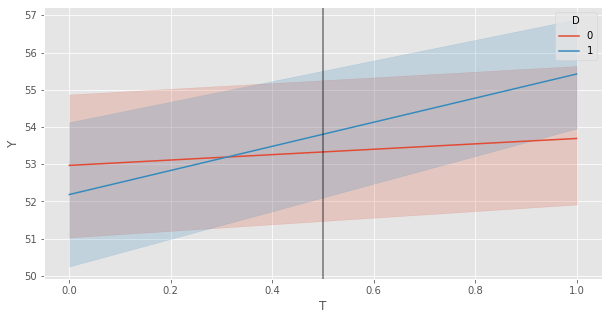

In [16]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
sns.lineplot(x="T", y="Y", hue="D",  data=df_rcs, ax=ax)
ax.axvline(x=0.5, alpha=0.5, color = "black")
plt.show()

In [17]:
y_col = "Y"
d_col = "D"
t_col = "T"
X_cols = [col for col in df_rcs.columns if "x" in col]

In [18]:
linear_dmldid = DMLDiD_RCS(
    #d_model= LogisticRegression(penalty='l1', C=0.359381, random_state=0, solver='saga'),
    #l2k_model=LassoCV(cv=5, random_state=333),
    )
lgbm_dmldid = DMLDiD_RCS(
    d_model= LGBMClassifier(random_state=0),
    l2k_model=LGBMRegressor(random_state=0),
    )

In [19]:
linear_dmldid.fit(
    df_rcs,
    y_col,
    d_col,
    t_col,
    X_cols,
    dmldid=True,
    sim_cnt=100,
    base_random_seed=0,
    progress_plot=True,
    d_model_t0_only=True
)
algo_modified_bar = linear_dmldid.sim_att_result()

99. att :  2.9575125452350495


In [20]:
lgbm_dmldid.fit(
    df_rcs,
    y_col,
    d_col,
    t_col,
    X_cols,
    dmldid=True,
    sim_cnt=100,
    base_random_seed=0,
    progress_plot=True,
    d_model_t0_only=True
)
algo_modified_bar_lgbm = lgbm_dmldid.sim_att_result()

99. att :  2.2269729921364996


In [21]:
def original_dmldid_rcs(
    df,
    y_col,
    d_col,
    t_col,
    X_cols,
    d_model=LogisticRegressionCV(cv=5, random_state=333, penalty="l1", solver="saga"),
    l2k_model=LassoCV(cv=5, random_state=333),
    original=True,
):
    B = 100
    K = 2  # ２分割

    thetabar = []

    for l in tqdm(range(B)):
        df_set = train_test_split(df, random_state=l, test_size=0.5)
        _thetabar = []
        for i in range(K):
            k = 0 if i == 0 else 1
            c = 1 if i == 0 else 0
            d_model.fit(df_set[c][X_cols], df_set[c][d_col])

            eps = 0.03
            if original and hasattr(d_model, "coef_"):
                z = df_set[k][X_cols] @ d_model.coef_.T
                ghat = 1 / (1 + np.exp(-1 * z))
            else:
                ghat = d_model.predict_proba(df_set[k][X_cols])[:, 1]

            cal_index = (eps <= ghat) & (ghat <= 1 - eps)

            ghat = np.clip(
                d_model.predict_proba(df_set[k][X_cols])[:, 1],
                eps,
                1 - eps,
            )

            lamda_hat = df_set[c][t_col].mean()
            if original:
                p_hat = df_set[k][d_col].mean()  # 本当はｃでは？
            else:
                p_hat = df_set[c][d_col].mean()

            control_y = df_set[c].query(f"{d_col} < 1")[y_col]
            control_t = df_set[c].query(f"{d_col} < 1")[t_col]
            control_x = df_set[c].query(f"{d_col} < 1")[X_cols]

            _y = (control_t - lamda_hat) * control_y

            l2k_model.fit(control_x, _y)

            if original and hasattr(l2k_model, "coef_"):
                l2k_hat = df_set[k][X_cols] @ l2k_model.coef_.T  # 間違い　切片が消えてる
            else:
                l2k_hat = l2k_model.predict(df_set[k][X_cols])

            _c = (
                ((df_set[k][t_col] - lamda_hat) * df_set[k][y_col] - l2k_hat)
                * (df_set[k][d_col] - ghat)
                / ((1 - ghat) * lamda_hat * (1 - lamda_hat) * p_hat)
            )


#             if original:
#                 _c = _c[cal_index]

            if original:
                _thetabar.append(_c[_c <= abs(_c.min())].mean())
            else:
                _thetabar.append(_c.mean())

        thetabar.append(np.mean(_thetabar))
    return thetabar

In [22]:
original_bar = original_dmldid_rcs(df_rcs, y_col, d_col, t_col, X_cols)

100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


In [23]:
original_bar_few_fixed = original_dmldid_rcs(df_rcs, y_col, d_col, t_col, X_cols, original=False)

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


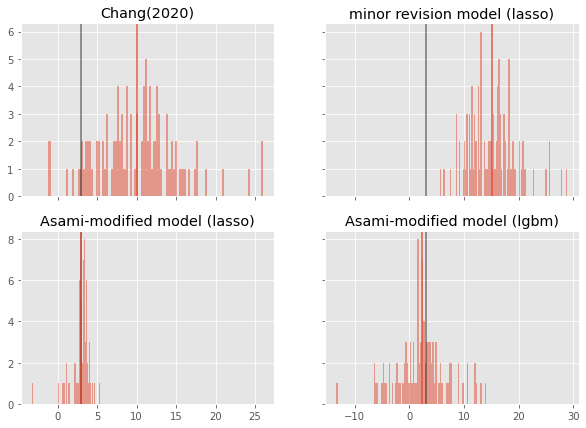

In [24]:
_label = ["Chang(2020)", "minor revision model (lasso)", "Asami-modified model (lasso)","Asami-modified model (lgbm)"]
result_df = pd.DataFrame(
    {
        "original_bar" : original_bar,
        "few_fixed_bar" : original_bar_few_fixed, 
        "algo_modified_bar" : algo_modified_bar ,
        "algo_modified_bar_lgbm" : algo_modified_bar_lgbm,
    }
)
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10,7))
ax = ax.ravel() 
for i, _col in enumerate(result_df.columns):
    ax[i].hist(result_df[_col], bins=100, alpha=0.5)
    #ax[i].set_xlim(0,5)
    ax[i].set_title(_label[i])
    ax[i].axvline(x=3, alpha=0.5, color = "black")
    ax[i].axvline(x=result_df[_col].mean(), alpha=0.9)
plt.show()